In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import HTML

import pickle

import seaborn as sns
import collections
import networkx as nx
import copy
import time
import os

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure

import gpflow

from graph_kernels import data_utils
from graph_kernels import utils
from graph_kernels import time_kernels
from graph_kernels import utils_opt
from graph_kernels import utils_postproc

figure(num=None, figsize=(28, 28), dpi=80, facecolor='w', edgecolor='k')

gpflow.config.set_default_jitter(1e-4)

<Figure size 2240x2240 with 0 Axes>

In [13]:
PATH_TO_DATA_FOLDER = ("../data/wave/")
PATH_X = os.path.join(PATH_TO_DATA_FOLDER, "X.pkl")
PATH_Y = os.path.join(PATH_TO_DATA_FOLDER, "y.pkl")
PATH_GRAPH = os.path.join(PATH_TO_DATA_FOLDER, "graph.pkl")
graph = pickle.load(open(PATH_GRAPH, "rb"))
N_NODES = len(graph.nodes())

DUMP_DIRECTORY = "dump_directory"
os.makedirs(DUMP_DIRECTORY, exist_ok=True)
os.makedirs("images", exist_ok=True)

In [3]:
NUM_TEST_WEEKS = 2
NUM_TRAIN = 50 * N_NODES
NUM_TEST = NUM_TEST_WEEKS * N_NODES
START = 4 * N_NODES * 2
N_ITER = 5_000
RANDOM_SEEDS = [23, 42, 82, 100, 123, 223,
                2 * 23, 2 * 42, 2 * 82, 2 * 100, 2 * 123, 2 * 223]

In [4]:
X = pickle.load(open(PATH_X, "rb"))
y = pickle.load(open(PATH_Y, "rb"))

In [5]:
kernels = {
    "td_laplacian": time_kernels.TimeDistributedLaplacianKernel(graph),
    "td_matern_nu_52_k_1": time_kernels.TimeDistributedMaternKernel(graph, nu=5/2, kappa=1),
    "td_matern_nu_32_k_1": time_kernels.TimeDistributedMaternKernel(graph, nu=3/2, kappa=1),
    "td_matern_nu_12_k_1": time_kernels.TimeDistributedMaternKernel(graph, nu=1/2, kappa=1),
    "stoch_heat_vector_pseudo_diff_1": time_kernels.StochasticHeatEquation(graph,
       c=0.1, use_pseudodifferential=True, nu=5/2,
       kappa=1, variance=[1.]*len(graph.nodes())),
    "stoch_heat_vector_pseudo_diff_2": time_kernels.StochasticHeatEquation(graph,
       c=0.1, use_pseudodifferential=True, nu=3/2,
       kappa=1, variance=[1.]*len(graph.nodes())),
    "stoch_heat_vector_pseudo_diff_3": time_kernels.StochasticHeatEquation(graph,
       c=0.1, use_pseudodifferential=True, nu=1/2,
       kappa=1, variance=1.),
    "stoch_wave_kernel_nu_12": time_kernels.StochasticWaveEquationKernel(
        graph, c=0.1, use_pseudodifferential=True, nu=1 / 2, kappa=10,
        variance=1.0),
    "stoch_wave_kernel_nu_32": time_kernels.StochasticWaveEquationKernel(
        graph, c=0.1, use_pseudodifferential=True, nu=3 / 2, kappa=1,
        variance=1.0),
    "stoch_wave_kernel_nu_52": time_kernels.StochasticWaveEquationKernel(
        graph, c=0.1, use_pseudodifferential=True, nu=5 / 2, kappa=10,
        variance=1.0),
}

In [6]:
results = collections.defaultdict(dict)

In [7]:
#kernel_name = "stoch_heat_vector_pseudo_diff_3"
kernel_name = "stoch_wave_kernel_nu_52"

for i, rs in enumerate(RANDOM_SEEDS):
    kernel = copy.deepcopy(kernels[kernel_name])
    utils.set_all_random_seeds(rs)

    utils.set_all_random_seeds(rs)
    train_X, train_y, test_X, test_y, qt = data_utils.generate_dataset(
        X, y, NUM_TRAIN, NUM_TEST,
        start=START + 10 * len(graph.nodes()) + i * len(graph.nodes()), log_target=False, rs=rs,
        interpolation=False)
    start = time.time()
    result, gprocess = utils_opt.evaluate_kernel_mcmc(
        kernel, train_X, train_y, test_X, test_y, graph,
        n_iter=N_ITER, dump_everything=False, dump_directory=DUMP_DIRECTORY)
    results[kernel_name][rs] = result

0:	ELBO: -522.78695	MAPE: 49411083745101.2500000000	MAE: 0.0494760289
1:	ELBO: -649.60072	MAPE: 87218169830742.5468750000	MAE: 0.0515282197
2:	ELBO: -824.59367	MAPE: 90807941555610.4375000000	MAE: 0.0511540748
3:	ELBO: -955.31851	MAPE: 68342742878235.9453125000	MAE: 0.0404082756
4:	ELBO: -1152.45533	MAPE: 35426937814843.6562500000	MAE: 0.0236137586
5:	ELBO: -1193.72487	MAPE: 41640826968279.1250000000	MAE: 0.0249512851
6:	ELBO: -1221.01163	MAPE: 47917634274505.5546875000	MAE: 0.0315043598
7:	ELBO: -1256.06121	MAPE: 40104203824625.6015625000	MAE: 0.0250922668
8:	ELBO: -1260.73102	MAPE: 39114375409547.6875000000	MAE: 0.0243952481
9:	ELBO: -1266.31820	MAPE: 38759128574627.7812500000	MAE: 0.0245500426
10:	ELBO: -1271.73075	MAPE: 37424899169070.4375000000	MAE: 0.0247418769
11:	ELBO: -1276.20968	MAPE: 37220355215276.4453125000	MAE: 0.0242883255
12:	ELBO: -1283.45992	MAPE: 36377933381502.3750000000	MAE: 0.0246828267
13:	ELBO: -1288.13708	MAPE: 36276255408576.1562500000	MAE: 0.0249266317
14:	EL

16:	ELBO: -1280.36431	MAPE: 15546901558672.8574218750	MAE: 0.0129894903
17:	ELBO: -1280.44238	MAPE: 15385211309965.7792968750	MAE: 0.0129066530
18:	ELBO: -1280.50935	MAPE: 15475481464456.0136718750	MAE: 0.0128813178
19:	ELBO: -1280.61932	MAPE: 15571246280553.9003906250	MAE: 0.0128116411
20:	ELBO: -1280.78383	MAPE: 15676141405980.3632812500	MAE: 0.0127725975
21:	ELBO: -1280.84693	MAPE: 15608953450839.4980468750	MAE: 0.0129810770
22:	ELBO: -1281.08525	MAPE: 15378824660799.0917968750	MAE: 0.0128606970
23:	ELBO: -1281.24122	MAPE: 15253448055387.7890625000	MAE: 0.0128130038
24:	ELBO: -1281.29833	MAPE: 14957941209521.7167968750	MAE: 0.0127707116
25:	ELBO: -1281.32528	MAPE: 14757430140586.4433593750	MAE: 0.0127867230
26:	ELBO: -1281.34251	MAPE: 14787518812107.8808593750	MAE: 0.0128147471
27:	ELBO: -1281.36941	MAPE: 14432609089545.5058593750	MAE: 0.0127594236
28:	ELBO: -1281.37592	MAPE: 14284464106198.2109375000	MAE: 0.0127099218
29:	ELBO: -1281.37761	MAPE: 14226667785677.9179687500	MAE: 0.012

35:	ELBO: -1277.20296	MAPE: 2491869431191.7231445312	MAE: 0.0143483481
36:	ELBO: -1277.20305	MAPE: 2500473875804.3549804688	MAE: 0.0143436384
37:	ELBO: -1277.20314	MAPE: 2517329376811.9497070312	MAE: 0.0143466934
38:	ELBO: -1277.20316	MAPE: 2524545864282.4096679688	MAE: 0.0143495128
39:	ELBO: -1277.20317	MAPE: 2524239721699.1132812500	MAE: 0.0143492165
40:	ELBO: -1277.20321	MAPE: 2526145043672.5214843750	MAE: 0.0143530467
41:	ELBO: -1277.20321	MAPE: 2529316333127.9990234375	MAE: 0.0143545050
42:	ELBO: -1277.20322	MAPE: 2531252419162.5708007812	MAE: 0.0143580824
43:	ELBO: -1277.20323	MAPE: 2533650810371.6552734375	MAE: 0.0143604720
0:	ELBO: -521.08905	MAPE: 68019517970247.7968750000	MAE: 0.0537527602
1:	ELBO: -665.51654	MAPE: 90936912331365.0156250000	MAE: 0.0684862582
2:	ELBO: -842.00021	MAPE: 3459708601475.0395507812	MAE: 0.0273101718
3:	ELBO: -1008.64442	MAPE: 31207104876703.4257812500	MAE: 0.0258855175
4:	ELBO: -1176.74560	MAPE: 4191272739107.7285156250	MAE: 0.0243821626
5:	ELBO: -1

9:	ELBO: -1284.04337	MAPE: 34579609470771.3750000000	MAE: 0.0166230177
10:	ELBO: -1285.04661	MAPE: 33574613956859.9882812500	MAE: 0.0171819991
11:	ELBO: -1285.27593	MAPE: 33148028469392.8476562500	MAE: 0.0171401894
12:	ELBO: -1285.72107	MAPE: 32195159015656.6640625000	MAE: 0.0168901387
13:	ELBO: -1285.98997	MAPE: 32172562807961.9375000000	MAE: 0.0169141533
14:	ELBO: -1286.29218	MAPE: 31796270688407.5351562500	MAE: 0.0169242702
15:	ELBO: -1286.48071	MAPE: 32253480303128.7851562500	MAE: 0.0169294422
16:	ELBO: -1286.53306	MAPE: 32534170601127.3476562500	MAE: 0.0168796419
17:	ELBO: -1286.54933	MAPE: 32669192992922.8398437500	MAE: 0.0169687413
18:	ELBO: -1286.57732	MAPE: 32531475290535.0781250000	MAE: 0.0169305335
19:	ELBO: -1286.59463	MAPE: 32375366356853.6992187500	MAE: 0.0168943717
20:	ELBO: -1286.60650	MAPE: 32242135353661.4023437500	MAE: 0.0168647321
21:	ELBO: -1286.60943	MAPE: 32246556005226.4101562500	MAE: 0.0168397106
22:	ELBO: -1286.61941	MAPE: 32134283897761.3164062500	MAE: 0.0168

33:	ELBO: -1292.26736	MAPE: 27911547138378.1875000000	MAE: 0.0251778071
34:	ELBO: -1292.26752	MAPE: 27916307742457.7148437500	MAE: 0.0251761525
35:	ELBO: -1292.26784	MAPE: 27919651561613.9375000000	MAE: 0.0251660100
36:	ELBO: -1292.26789	MAPE: 27905783991132.9218750000	MAE: 0.0251625553
37:	ELBO: -1292.26793	MAPE: 27886630284192.8242187500	MAE: 0.0251597554
38:	ELBO: -1292.26800	MAPE: 27851570831452.5625000000	MAE: 0.0251541377
39:	ELBO: -1292.26812	MAPE: 27799530143396.3007812500	MAE: 0.0251475663
40:	ELBO: -1292.26823	MAPE: 27737777633593.5000000000	MAE: 0.0251396172
41:	ELBO: -1292.26839	MAPE: 27681596721409.9218750000	MAE: 0.0251332861
42:	ELBO: -1292.26843	MAPE: 27689487680890.6718750000	MAE: 0.0251356992
43:	ELBO: -1292.26843	MAPE: 27694614935486.7382812500	MAE: 0.0251352941
44:	ELBO: -1292.26843	MAPE: 27695291540577.0351562500	MAE: 0.0251359912
0:	ELBO: -520.12121	MAPE: 19085964693587.7656250000	MAE: 0.0464643943
1:	ELBO: -665.83758	MAPE: 63045907583452.5078125000	MAE: 0.0377210

In [8]:
agg_kernel_results = utils_postproc.parse_results(results)

In [9]:
for kernel_name in results.keys():
    print(kernel_name)
    utils_postproc.stats_array([r["MAE"] for r in results[kernel_name].values()])
    print("====================================")

stoch_wave_kernel_nu_52
Mean: 0.0189 $\pm$ 0.0028
Confidence Interval 95%%: 0.01610405905604751, 0.021731816631653467
(0.01610405905604751, 0.021731816631653467)
Data:  [0.025276921027308018, 0.019689531058666873, 0.01286791425585474, 0.015034357473585053, 0.01436047199927747, 0.015805523963914877, 0.01709513207841518, 0.016351642022197983, 0.019562474216397095, 0.02513599117882034, 0.02532511004077812, 0.02051018481099016]


## Interpolation (2)
stoch_wave_kernel_nu_52
Mean: 0.0028 $\pm$ 0.0006
Confidence Interval 95%%: 0.0022401338710728927, 0.003451229086341565
(0.0022401338710728927, 0.003451229086341565)

Data:  [0.0017450406668729596, 0.004414391742788683, 0.004453214111611686, 0.0021427154657830167, 0.001821253925833599, 0.0024079721248159744, 0.0025783857412016963, 0.0022940820372391252, 0.0031607236224262952, 0.0022596849189193305, 0.003928416917940637, 0.0029422964690537417]

====================================

stoch_heat_vector_pseudo_diff_3
Mean: 0.0047 $\pm$ 0.0014
Confidence Interval 95%%: 0.003322288909083467, 0.0060250689146361955
(0.0033222889090834666, 0.006025068914636196)

Data:  [0.0039073701859408975, 0.00502979652575883, 0.007811263104709524, 0.002084047933587993, 0.004071909169771604, 0.0025462248547979053, 0.004087074038491602, 0.003633725543103668, 0.006207459554040093, 0.0028253794905910993, 0.009191976295210859, 0.004687920246313


## Extrapolation 
stoch_heat_vector_pseudo_diff_3
Mean: 0.0274 $\pm$ 0.0067
Confidence Interval 95%%: 0.020609731103628355, 0.03410758679848596
(0.020609731103628355, 0.03410758679848596)

Data:  [0.03236539513724462, 0.022677598991751556, 0.01165332385894794, 0.007914633900852069, 0.01911465579315055, 0.028778972004901007, 0.03587617517178525, 0.039150246636727705, 0.039725863943984634, 0.03717489520129039, 0.03130447329271192, 0.022567673479338222]

====================================

stoch_wave_kernel_nu_52
Mean: 0.0189 $\pm$ 0.0028
Confidence Interval 95%%: 0.01610405905604751, 0.021731816631653467
(0.01610405905604751, 0.021731816631653467)

Data:  [0.025276921027308018, 0.019689531058666873, 0.01286791425585474, 0.015034357473585053, 0.01436047199927747, 0.015805523963914877, 0.01709513207841518, 0.016351642022197983, 0.019562474216397095, 0.02513599117882034, 0.02532511004077812, 0.02051018481099016]

====================================



In [10]:
kernel = copy.deepcopy(kernels["stoch_wave_kernel_nu_52"])
#kernel = copy.deepcopy(kernels["stoch_heat_vector_pseudo_diff_3"])
utils.set_all_random_seeds(rs)

utils.set_all_random_seeds(rs)
train_X, train_y, test_X, test_y, qt = data_utils.generate_dataset(
    X, y, NUM_TRAIN, NUM_TEST,
    start=START + 10 * len(graph.nodes()), log_target=False, rs=rs,
    interpolation=True)
start = time.time()
result, gprocess = utils_opt.evaluate_kernel_mcmc(
    kernel, train_X, train_y, test_X, test_y, graph,
    n_iter=N_ITER, dump_everything=False, dump_directory=DUMP_DIRECTORY)
results[kernel_name][rs] = result

0:	ELBO: -474.96614	MAPE: 24645810085517.2578125000	MAE: 0.0296326765
1:	ELBO: -576.02563	MAPE: 19003437695932.1757812500	MAE: 0.0259727013
2:	ELBO: -713.54835	MAPE: 12498801157852.0820312500	MAE: 0.0201895766
3:	ELBO: -822.26806	MAPE: 13805302588245.2500000000	MAE: 0.0130924225
4:	ELBO: -1022.18304	MAPE: 7525847832508.3515625000	MAE: 0.0059436819
5:	ELBO: -1048.62851	MAPE: 6051768189694.6757812500	MAE: 0.0051288084
6:	ELBO: -1076.66693	MAPE: 4967651560894.9482421875	MAE: 0.0042977134
7:	ELBO: -1087.22058	MAPE: 3988782965217.1567382812	MAE: 0.0040269194
8:	ELBO: -1094.16457	MAPE: 4297801887967.3291015625	MAE: 0.0039813612
9:	ELBO: -1098.30482	MAPE: 4165111177225.1972656250	MAE: 0.0038234018
10:	ELBO: -1107.26751	MAPE: 3840882090748.3291015625	MAE: 0.0034909915
11:	ELBO: -1113.32152	MAPE: 3623277855807.8310546875	MAE: 0.0033348642
12:	ELBO: -1120.58866	MAPE: 3591378790111.0405273438	MAE: 0.0032380606
13:	ELBO: -1124.32423	MAPE: 3654870613543.1000976562	MAE: 0.0032316609
14:	ELBO: -1128.

In [14]:
def filter_ds(X, y, node_id):
    inds = [i for i in range(X.shape[0]) if X[i, 0] == node_id]
    return X[inds], np.array(y)[inds][:]


def plot(m, X_train, signal, node_id):
    xmin, xmax = 0.5, 5
    xx = np.linspace(xmin, xmax, 100)
    xx = np.array([[node_id, x] for x in xx])
    
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    X_train, signal = filter_ds(X_train, signal, node_id)
    plt.plot(X_train[:, 1], signal, 'kx', mew=2)
    plt.plot(xx[:, 1], mean, 'b', lw=2)
    plt.fill_between(xx[:, 1], mean[:, 0] - 2 * np.sqrt(var[:, 0]), mean[:, 0] + 2 * np.sqrt(var[:, 0]), color='blue', alpha=0.2)
    plt.xlim(xmin, xmax)
    plt.title("Fit of GP (SWEK) model to synthetic wave dataset (node: {})".format(node_id), fontsize=24)
    plt.savefig("images/swek_fit_wave_{}.pdf".format(node_id))

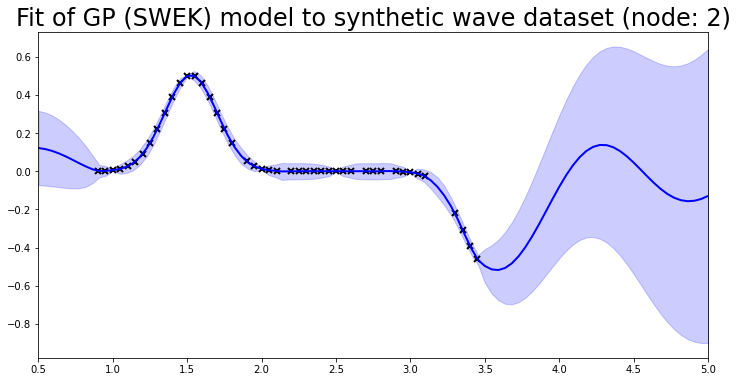

In [15]:
plot(gprocess, train_X, train_y, 2)